In [137]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [66]:
# today's date string for file naming automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-03-07.csv'

print(today_date_str)

_2024-03-11.csv


In [67]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1176 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,AAPL,Apple Inc.,NASDAQ,2636392253146,USD,170.73,USD,171.00,USD,2.04,USD,1.194869,0.158144,15427909638.6,76266505,393261729,645060,7.476463e+07,61053401.53333382,56388274.39999982,2.817568,1.776185,1.568710,171.123333,26.56449354,Electronic Technology,0.87238385,1.06712,1.2041771,1.2891104,4.699136,4.775449,3.102821,2.131078,1.035981,0.615886,0.802548,1.064432,1.52634414,0.39175434,189.990,USD,199.62,USD,199.62,USD,199.62,USD,199.620000,USD,171.345,USD,171.4700,USD,171.7328,USD,171.7328,USD,171.7328,USD,173.700,USD,173.700,USD,176.900,USD,180.53,USD,2380652.17391304,USD,170.95800,171.066875,171.1250,171.760969,171.452370,171.162730,170.873090,174.034678,172.273370,170.512062
1,GOOG,Alphabet Inc.,NASDAQ,1688542996689,USD,136.29,USD,136.13,USD,0.75,USD,0.550297,-0.117397,5277750176,26494430,145795972,108394,2.963381e+07,25350156.93333337,22350469.90000001,3.104599,2.463250,1.922458,136.691667,23.47722731,Technology Services,0.70494811,1.021201,1.1586931,1.0489115,5.942181,5.836621,3.725545,2.159699,1.101765,0.591959,0.599773,0.931711,1.4754574,0.36115306,150.695,USD,155.20,USD,155.20,USD,155.20,USD,155.200000,USD,136.565,USD,136.5850,USD,136.5850,USD,136.5850,USD,136.5850,USD,137.170,USD,138.985,USD,138.985,USD,140.00,USD,1683033.61059057,USD,136.41198,136.403112,136.3820,136.524877,136.565622,136.392495,136.219368,137.208154,136.648920,136.089686
2,GOOGL,Alphabet Inc.,NASDAQ,1688542996688.9998,USD,135.41,USD,135.25,USD,0.73,USD,0.539103,-0.118160,5871219472,39370316,208621307,150956,4.059745e+07,34980688.53333334,29774609.04444444,3.048507,2.495721,1.962727,135.831667,23.32563908,Technology Services,0.80240453,1.0305723,1.1459233,1.0442357,3.526613,4.881177,3.368677,1.973859,0.965876,0.539623,0.627396,1.019698,1.56655908,0.37931306,149.440,USD,153.78,USD,153.78,USD,153.78,USD,153.780000,USD,135.660,USD,135.6700,USD,135.6700,USD,135.6700,USD,135.6700,USD,136.235,USD,138.085,USD,138.085,USD,138.87,USD,1683033.61059057,USD,135.52400,135.498125,135.4680,135.587454,135.655508,135.469745,135.283982,136.249404,135.706345,135.163286
3,NVO,Novo Nordisk A/S,NYSE,594721816483.4071,USD,133.07,USD,134.05,USD,0.23,USD,0.172841,0.736455,3383416466.2

In [68]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [69]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,AAPL,Apple Inc.,NASDAQ,2.636392e+12,USD,170.73,USD,171.00,USD,2.04,USD,1.194869,0.158144,15427909638.6,76266505,393261729,645060,7.476463e+07,61053401.53333382,56388274.39999982,2.817568,1.776185,1.568710,171.123333,26.56449354,Electronic Technology,0.87238385,1.06712,1.2041771,1.2891104,4.699136,4.775449,3.102821,2.131078,1.035981,0.615886,0.802548,1.064432,1.52634414,0.39175434,189.990,USD,199.62,USD,199.62,USD,199.62,USD,199.620000,USD,171.345,USD,171.4700,USD,171.7328,USD,171.7328,USD,171.7328,USD,173.700,USD,173.700,USD,176.900,USD,180.53,USD,2380652.17391304,USD,170.95800,171.066875,171.1250,171.760969,171.452370,171.162730,170.873090,174.034678,172.273370,170.512062,Titans
1,GOOG,Alphabet Inc.,NASDAQ,1.688543e+12,USD,136.29,USD,136.13,USD,0.75,USD,0.550297,-0.117397,5277750176,26494430,145795972,108394,2.963381e+07,25350156.93333337,22350469.90000001,3.104599,2.463250,1.922458,136.691667,23.47722731,Technology Services,0.70494811,1.021201,1.1586931,1.0489115,5.942181,5.836621,3.725545,2.159699,1.101765,0.591959,0.599773,0.931711,1.4754574,0.36115306,150.695,USD,155.20,USD,155.20,USD,155.20,USD,155.200000,USD,136.565,USD,136.5850,USD,136.5850,USD,136.5850,USD,136.5850,USD,137.170,USD,138.985,USD,138.985,USD,140.00,USD,1683033.61059057,USD,136.41198,136.403112,136.3820,136.524877,136.565622,136.392495,136.219368,137.208154,136.648920,136.089686,Titans
2,GOOGL,Alphabet Inc.,NASDAQ,1.688543e+12,USD,135.41,USD,135.25,USD,0.73,USD,0.539103,-0.118160,5871219472,39370316,208621307,150956,4.059745e+07,34980688.53333334,29774609.04444444,3.048507,2.495721,1.962727,135.831667,23.32563908,Technology Services,0.80240453,1.0305723,1.1459233,1.0442357,3.526613,4.881177,3.368677,1.973859,0.965876,0.539623,0.627396,1.019698,1.56655908,0.37931306,149.440,USD,153.78,USD,153.78,USD,153.78,USD,153.780000,USD,135.660,USD,135.6700,USD,135.6700,USD,135.6700,USD,135.6700,USD,136.235,USD,138.085,USD,138.085,USD,138.87,USD,1683033.61059057,USD,135.52400,135.498125,135.4680,135.587454,135.655508,135.469745,135.283982,136.249404,135.706345,135.163286,Titans
3,NVO,Novo Nordisk A/S,NYSE,5.947218e+11,USD,133.07,USD,134.05,USD,0.23,USD,0.172841

In [70]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [71]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1176 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Small caps,284,24.149660
1,Shrimp,274,23.299320
2,Micro caps,247,21.003401
3,Midlers,185,15.731293
4,Large caps,151,12.840136
5,Titans,21,1.785714
6,Undefined,14,1.190476


In [72]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1162 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
86,EXC,Exelon Corporation,NASDAQ,3.694294e+10,USD,36.96,USD,36.82,USD,0.2700,USD,0.730519,-0.378788,997792806.652,6904790,33329948,938,6840787.2,7036829.39999999,7689840.88888889,1.505612,1.878168,2.002410,36.856667,15.82327254,Utilities,0.94050097,0.4454193,0.60613585,0.5279443,4.896536,9.073065,6.164362,3.543690,1.631591,0.951731,0.973261,1.045303,1.06255333,0.27758283,37.26,USD,41.425,USD,42.155,USD,43.71,USD,65.695047,USD,37.04,USD,37.08,USD,37.08,USD,37.08,USD,37.08,USD,37.080,USD,37.08,USD,37.26,USD,37.26,USD,1088417.99418896,USD,36.98000,37.005625,36.9992,37.010985,37.061284,37.010500,36.959716,37.054631,36.997765,36.940899,Large caps
285,RDNT,"RadNet, Inc.",NASDAQ,3.184793e+09,USD,46.51,USD,46.53,USD,0.0200,USD,0.043002,0.043002,58347203.586,2980881,6173914,100,990247.4,528790.23333333,474733.3,13.067785,6.354383,4.416091,45.503333,51677.77777778,Health Services,2.73264864,1.4668574,1.275731,1.658292,5.442802,4.218351,3.246909,1.980163,0.878928,0.742323,1.157368,4.147691,3.43364625,0.77044048,49.41,USD,49.410,USD,49.410,USD,49.41,USD,49.410000,USD,46.65,USD,46.71,USD,46.82,USD,46.82,USD,46.82,USD,46.830,USD,47.07,USD,49.41,USD,49.41,USD,205364.58333333,USD,46.53302,46.501888,46.6002,46.572000,46.831572,46.568805,46.306038,46.873902,46.479550,46.085198,Midlers
649,NRGV,"Energy Vault Holdings, Inc.",NYSE,2.856560e+08,USD,1.99,USD,2.00,USD,0.0593,USD,2.979900,0.502513,68563742.07800001,1297139,3241071,5866,580958.4,726121.93333333,871260.57777778,13.927577,7.595908,7.235757,1.935000,-,Producer Manufacturing,2.11281884,2.510973,0.55618,0.55618,1.983857,4.846472,2.058534,2.265359,1.592397,1.137647,3.050097,2.642279,0.8295362,0.18921765,2.02,USD,2.680,USD,3.250,USD,3.55,USD,22.100000,USD,2.00,USD,2.00,USD,2.00,USD,2.00,USD,2.00,USD,2.020,USD,2.02,USD,2.02,USD,2.02,USD,824163.84180791,USD,1.99792,1.993688,1.9860,1.988900,2.001854,1.986405,1.970956,2.008821,1.984785,1.960749,Micro caps
367,NPWR,NET Power Inc.,NYSE,1.838754e+09,USD,8.63,USD,8.70,USD,0.0300,USD,0.347625,0.811124,18922081.0936,455178,1400789,604,274160.7,242072,280300.35555556,4.107981,4.112417,5.038395,8.666667,-,Producer Manufacturing,1.51110177,-0.704360

In [73]:
# drop undefined
tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

market_cap_type_df2
print(market_cap_type_df2)


  marketCapType  count  percentage
0    Small caps    284   24.440620
1        Shrimp    274   23.580034
2    Micro caps    247   21.256454
3       Midlers    185   15.920826
4    Large caps    151   12.994836
5        Titans     21    1.807229


In [74]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [75]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 1162
Number of rows removed: 1155
NEW DataFrame length: 7


In [76]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Small caps,3,42.857143
1,Large caps,2,28.571429
2,Midlers,1,14.285714
3,Shrimp,1,14.285714


In [77]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Large caps' 'Midlers' 'Small caps' 'Shrimp']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relative Volume 1 week', 'R

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,EDU,"New Oriental Education & Technology Group, Inc...",NYSE,1.497948e+10,USD,90.17,USD,90.47,USD,0.13,USD,0.144172,0.332705,1.654587e+08,2687256,9137894,3692,1524569.7,1768768.69999998,1785831.22222223,5.488575,3.932455,3.286652,89.710000,49.21137368,Consumer Services,1.490119,1.1611879,0.24545807,0.5030385,2.555885,6.406386,7.290278,2.120533,0.976995,0.602067,0.689005,1.893552,1.07552366,0.29500058,98.200,USD,98.20,USD,98.200,USD,98.20,USD,199.7400,USD,90.250,USD,90.25,USD,90.25,USD,90.25,USD,90.25,USD,90.36,USD,91.87,USD,98.20,USD,98.200,USD,54007.85500667,USD,90.15500,90.143750,89.99200,90.014231,90.274081,89.98081,89.687539,90.243335,89.940500,89.637665,Large caps
1,ONON,On Holding AG,NYSE,1.047365e+10,USD,33.09,USD,33.84,USD,0.16,USD,0.483530,2.266546,1.876031e+08,6576098,30306742,34748,5341704.4,4837171.2,5054020.62222222,3.581905,3.184276,3.365261,32.885000,118.68723099,Consumer Non-Durables,0.979479,1.6530961,2.179955,2.179955,2.480428,3.250074,3.452546,2.385260,1.209855,0.724526,0.673585,1.319468,1.33320761,0.36159538,35.580,USD,35.58,USD,35.580,USD,37.08,USD,55.8700,USD,33.100,USD,33.11,USD,33.11,USD,33.11,USD,33.11,USD,33.11,USD,33.18,USD,34.72,USD,35.125,USD,752262.56024297,USD,33.07398,33.066862,33.01400,32.953000,33.110527,33.01462,32.918713,33.086952,32.934450,32.781948,Large caps
2,MTN,"Vail Resorts, Inc.",NYSE,8.495413e+09,USD,223.76,USD,224.60,USD,0.24,USD,0.107258,0.375402,3.752368e+07,720663,3615720,1194,535531.6,400322.9,393717.48888889,3.635113,3.531393,2.202390,222.566667,41.53472055,Consumer Services,1.212317,1.1425825,0.7754122,1.1195556,5.844120,10.808708,8.242927,4.580450,1.703201,1.009830,0.718746,1.464385,2.06868201,0.48192066,236.920,USD,236.92,USD,254.780,USD,258.13,USD,376.2400,USD,224.365,USD,224.91,USD,225.47,USD,225.47,USD,225.47,USD,225.79,USD,225.79,USD,235.81,USD,235.810,USD,50869.08450704,USD,224.14100,224.090000,224.43300,224.837692,225.108001,224.38350,223.658999,225.762724,224.692750,223.622776,Midlers
3,AFYA,Afya Limited,NASDAQ,1.941000e+09,USD,20.71,USD,21.00,USD,0.29,USD,1.400290,1.400290,1.798361e+07,131873,355394,992,66157.6,89576.43333333,155568.8,4.214407,2.344296,2.535

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [78]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [79]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [80]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [81]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 7/7 [00:00<00:00, 1075.78it/s]


In [82]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.head()

START date: 2023-10-12
END date: 2024-03-08
102 days of historical stock data.

714 = Length of dataframe
7 = Unique stocks in dataframe
102.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['EDU', 'ONON', 'MTN', 'AFYA', 'GRND', 'NMM', 'PRSO']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
0,62.65,65.380,62.24,64.86,2023-10-12,EDU,1185528.0,HISTORICAL_PRICES,EDU,,2023-10-12,1697164226000,0.000000,0.000000,64.86,62.65,65.380,62.24,1185528,64.86,62.65,65.380,62.24,1185528.0,"Oct 12, 23",0.00,0.0000,EDU
1,62.37,63.170,61.90,61.97,2023-10-13,EDU,669074.0,HISTORICAL_PRICES,EDU,,2023-10-13,1697247056000,-0.004469,-0.004469,61.97,62.37,63.170,61.90,669074,61.97,62.37,63.170,61.90,669074.0,"Oct 13, 23",-0.28,-0.0045,EDU
2,62.82,63.365,61.23,61.42,2023-10-16,EDU,622083.0,HISTORICAL_PRICES,EDU,,2023-10-16,1697504424000,0.002713,0.002713,61.42,62.82,63.365,61.23,622083,61.42,62.82,63.365,61.23,622083.0,"Oct 16, 23",0.45,0.0072,EDU
3,61.99,63.000,61.66,62.14,2023-10-17,EDU,535338.0,HISTORICAL_PRICES,EDU,,2023-10-17,1697590887000,-0.010535,-0.010535,62.14,61.99,63.000,61.66,535338,62.14,61.99,63.000,61.66,535338.0,"Oct 17, 23",-0.83,-0.0132,EDU
4,61.92,63.160,61.17,61.20,2023-10-18,EDU,762499.0,HISTORICAL_PRICES,EDU,,2023-10-18,1697677253000,-0.011652,-0.011652,61.20,61.92,63.160,61.17,762499,61.20,61.92,63.160,61.17,762499.0,"Oct 18, 23",-0.07,-0.0011,EDU


In [83]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [84]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,AFYA,2024-03-08,20.71,20.92,20.074,20.22,131873.0
1,EDU,2024-03-08,90.17,91.87,87.090,90.00,2687256.0
2,GRND,2024-03-08,9.35,9.67,9.050,9.33,1352025.0
3,MTN,2024-03-08,223.76,225.79,218.150,221.90,720663.0
4,NMM,2024-03-08,44.30,44.33,41.400,41.50,513793.0
5,ONON,2024-03-08,33.09,33.18,32.385,32.62,6576098.0
6,PRSO,2024-03-08,1.83,1.85,1.610,1.63,597897.0


In [85]:
# re-index the dataframe
chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 714


In [86]:
"""
YOUR DATAFRAMES TO MOVE FORWARD WITH:
"""
#### INFO / NEWS DATAFRAME ####
print(f'1 - NEWS & STOCK INFO (trending news etc.):\n{info_news_df}\n')

#### IEX (API) - HISTORICAL DATA FRAME ####
print('2a - IEX HISTORICAL data (START):')
print(f'{chart_historical_df.head()}\n')
print('2b - IEX HISTORICAL data (END):')
print(f'{chart_historical_df.tail()}\n')

1 - NEWS & STOCK INFO (trending news etc.):
  Symbol                                        Description Exchange  \
0    EDU  New Oriental Education & Technology Group, Inc...     NYSE   
1   ONON                                      On Holding AG     NYSE   
2    MTN                                 Vail Resorts, Inc.     NYSE   
3   AFYA                                       Afya Limited   NASDAQ   
4   GRND                                        Grindr Inc.     NYSE   
5    NMM                        Navios Maritime Partners LP     NYSE   
6   PRSO                                        Peraso Inc.   NASDAQ   

  marketCapType  Market capitalization  
0    Large caps           1.497948e+10  
1    Large caps           1.047365e+10  
2       Midlers           8.495413e+09  
3    Small caps           1.941000e+09  
4    Small caps           1.636141e+09  
5    Small caps           1.337168e+09  
6        Shrimp           2.353999e+06  

2a - IEX HISTORICAL data (START):
  symbol        

In [87]:
#### TRADINGVIEW (IMPORTED) - DATAFRAME (TODAY'S DATA) ####
print('3 - TRADINGVIEW (IMPORTED) - DATAFRAME (TODAY):')
print(f'U.S. stocks returned from the pre-market gap up screener = {len(tv_L2_df.index)}')
tv_L2_df

3 - TRADINGVIEW (IMPORTED) - DATAFRAME (TODAY):
U.S. stocks returned from the pre-market gap up screener = 7


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,EDU,"New Oriental Education & Technology Group, Inc...",NYSE,1.497948e+10,USD,90.17,USD,90.47,USD,0.13,USD,0.144172,0.332705,1.654587e+08,2687256,9137894,3692,1524569.7,1768768.69999998,1785831.22222223,5.488575,3.932455,3.286652,89.710000,49.21137368,Consumer Services,1.490119,1.1611879,0.24545807,0.5030385,2.555885,6.406386,7.290278,2.120533,0.976995,0.602067,0.689005,1.893552,1.07552366,0.29500058,98.200,USD,98.20,USD,98.200,USD,98.20,USD,199.7400,USD,90.250,USD,90.25,USD,90.25,USD,90.25,USD,90.25,USD,90.36,USD,91.87,USD,98.20,USD,98.200,USD,54007.85500667,USD,90.15500,90.143750,89.99200,90.014231,90.274081,89.98081,89.687539,90.243335,89.940500,89.637665,Large caps
1,ONON,On Holding AG,NYSE,1.047365e+10,USD,33.09,USD,33.84,USD,0.16,USD,0.483530,2.266546,1.876031e+08,6576098,30306742,34748,5341704.4,4837171.2,5054020.62222222,3.581905,3.184276,3.365261,32.885000,118.68723099,Consumer Non-Durables,0.979479,1.6530961,2.179955,2.179955,2.480428,3.250074,3.452546,2.385260,1.209855,0.724526,0.673585,1.319468,1.33320761,0.36159538,35.580,USD,35.58,USD,35.580,USD,37.08,USD,55.8700,USD,33.100,USD,33.11,USD,33.11,USD,33.11,USD,33.11,USD,33.11,USD,33.18,USD,34.72,USD,35.125,USD,752262.56024297,USD,33.07398,33.066862,33.01400,32.953000,33.110527,33.01462,32.918713,33.086952,32.934450,32.781948,Large caps
2,MTN,"Vail Resorts, Inc.",NYSE,8.495413e+09,USD,223.76,USD,224.60,USD,0.24,USD,0.107258,0.375402,3.752368e+07,720663,3615720,1194,535531.6,400322.9,393717.48888889,3.635113,3.531393,2.202390,222.566667,41.53472055,Consumer Services,1.212317,1.1425825,0.7754122,1.1195556,5.844120,10.808708,8.242927,4.580450,1.703201,1.009830,0.718746,1.464385,2.06868201,0.48192066,236.920,USD,236.92,USD,254.780,USD,258.13,USD,376.2400,USD,224.365,USD,224.91,USD,225.47,USD,225.47,USD,225.47,USD,225.79,USD,225.79,USD,235.81,USD,235.810,USD,50869.08450704,USD,224.14100,224.090000,224.43300,224.837692,225.108001,224.38350,223.658999,225.762724,224.692750,223.622776,Midlers
3,AFYA,Afya Limited,NASDAQ,1.941000e+09,USD,20.71,USD,21.00,USD,0.29,USD,1.400290,1.400290,1.798361e+07,131873,355394,992,66157.6,89576.43333333,155568.8,4.214407,2.344296,2.535

In [88]:
"""PICK UP HERE WHERE YOU LEFT OFF"""
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


'PICK UP HERE WHERE YOU LEFT OFF'

| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [89]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,EDU,2023-10-12,62.65,65.3800,62.240,64.86,1185528.00
1,AFYA,2023-10-12,15.43,15.5400,15.110,15.54,168134.00
2,NMM,2023-10-12,22.87,23.0696,22.830,23.00,37731.00
3,ONON,2023-10-12,23.78,24.9800,23.720,24.75,4937950.00
4,PRSO,2023-10-12,7.20,7.3520,6.592,6.80,12245.15


In [90]:
"""
IMPORTANT:
for effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). 
"""
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

# view the multi-indexed dataframe
chart_historical_df.head()

,symbol,close,high,low,open,volume
date,,,,,,
2023-10-12,EDU,62.65,65.3800,62.240,64.86,1185528.00
2023-10-12,AFYA,15.43,15.5400,15.110,15.54,168134.00
2023-10-12,NMM,22.87,23.0696,22.830,23.00,37731.00
2023-10-12,ONON,23.78,24.9800,23.720,24.75,4937950.00
2023-10-12,PRSO,7.20,7.3520,6.592,6.80,12245.15


In [91]:
"""SIMPLE MOVING AVERAGES (SMA)"""
def calculate_sma(dataframe, period):
    return dataframe['close'].rolling(window=period).mean()

chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

chart_historical_df.tail(10)


,symbol,close,high,low,open,volume,SMA5,SMA10,SMA15
date,,,,,,,,,
2024-03-07,AFYA,20.19,20.3600,20.015,20.240,46856.0,65.578,62.303,71.082667
2024-03-07,PRSO,1.64,1.7200,1.575,1.575,132904.0,20.690,62.310,64.874000
2024-03-07,EDU,90.47,93.9105,89.760,93.110,2243620.0,30.606,48.486,70.798000
2024-03-08,NMM,44.30,44.3300,41.400,41.500,513793.0,37.724,52.091,59.147333
2024-03-08,EDU,90.17,91.8700,87.090,90.000,2687256.0,49.354,59.085,58.816667
2024-03-08,MTN,223.76,225.7900,218.150,221.900,720663.0,90.068,77.823,71.558000
2024-03-08,GRND,9.35,9.6700,9.050,9.330,1352025.0,91.610,56.150,72.076667
2024-03-08,ONON,33.09,33.1800,32.385,32.620,6576098.0,80.134,55.370,59.035333
2024-03-08,AFYA,20.71,20.9200,20.074,20.220,131873.0,75.416,56.570,59.866000


In [92]:
"""EXPONENTIAL MOVING AVERAGES (EMA)"""
def calculate_ema(dataframe, period):
    return dataframe['close'].ewm(span=period, adjust=False).mean()

# calculate EMAs for the specified periods
chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

chart_historical_df.tail(10)


,symbol,close,high,low,open,volume,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50
date,,,,,,,,,,,,,
2024-03-07,AFYA,20.19,20.3600,20.015,20.240,46856.0,65.578,62.303,71.082667,40.689459,53.355453,58.716879,59.857816
2024-03-07,PRSO,1.64,1.7200,1.575,1.575,132904.0,20.690,62.310,64.874000,27.672973,43.952643,53.280986,57.574765
2024-03-07,EDU,90.47,93.9105,89.760,93.110,2243620.0,30.606,48.486,70.798000,48.605315,52.410344,56.822797,58.864774
2024-03-08,NMM,44.30,44.3300,41.400,41.500,513793.0,37.724,52.091,59.147333,47.170210,50.935736,55.630150,58.293606
2024-03-08,EDU,90.17,91.8700,87.090,90.000,2687256.0,49.354,59.085,58.816667,61.503473,58.069239,58.919659,59.543661
2024-03-08,MTN,223.76,225.7900,218.150,221.900,720663.0,90.068,77.823,71.558000,115.588982,88.194832,74.618739,65.983517
2024-03-08,GRND,9.35,9.6700,9.050,9.330,1352025.0,91.610,56.150,72.076667,80.175988,73.859408,68.402669,63.762595
2024-03-08,ONON,33.09,33.1800,32.385,32.620,6576098.0,80.134,55.370,59.035333,64.480659,66.446788,65.039558,62.559748
2024-03-08,AFYA,20.71,20.9200,20.074,20.220,131873.0,75.416,56.570,59.866000,49.890439,58.131009,60.817695,60.918582


In [93]:
"""MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# calculate the MACD line and the Signal line
chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

chart_historical_df.tail(10)

,symbol,close,high,low,open,volume,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram
date,,,,,,,,,,,,,,,,
2024-03-07,AFYA,20.19,20.3600,20.015,20.240,46856.0,65.578,62.303,71.082667,40.689459,53.355453,58.716879,59.857816,-3.905872,2.149545,-6.055417
2024-03-07,PRSO,1.64,1.7200,1.575,1.575,132904.0,20.690,62.310,64.874000,27.672973,43.952643,53.280986,57.574765,-7.910359,0.137564,-8.047924
2024-03-07,EDU,90.47,93.9105,89.760,93.110,2243620.0,30.606,48.486,70.798000,48.605315,52.410344,56.822797,58.864774,-3.871478,-0.664244,-3.207234
2024-03-08,NMM,44.30,44.3300,41.400,41.500,513793.0,37.724,52.091,59.147333,47.170210,50.935736,55.630150,58.293606,-4.346070,-1.400609,-2.945460
2024-03-08,EDU,90.17,91.8700,87.090,90.000,2687256.0,49.354,59.085,58.816667,61.503473,58.069239,58.919659,59.543661,-1.009228,-1.322333,0.313105
2024-03-08,MTN,223.76,225.7900,218.150,221.900,720663.0,90.068,77.823,71.558000,115.588982,88.194832,74.618739,65.983517,12.273361,1.396806,10.876555
2024-03-08,GRND,9.35,9.6700,9.050,9.330,1352025.0,91.610,56.150,72.076667,80.175988,73.859408,68.402669,63.762595,5.436148,2.204674,3.231474
2024-03-08,ONON,33.09,33.1800,32.385,32.620,6576098.0,80.134,55.370,59.035333,64.480659,66.446788,65.039558,62.559748,1.911196,2.145979,-0.234783
2024-03-08,AFYA,20.71,20.9200,20.074,20.220,131873.0,75.416,56.570,59.866000,49.890439,58.131009,60.817695,60.918582,-1.859877,1.344808,-3.204684


In [94]:
#### DEV - DATA ORGANIZATION ####
chart_historical_df.columns

Index(['symbol', 'close', 'high', 'low', 'open', 'volume', 'SMA5', 'SMA10',
       'SMA15', 'EMA5', 'EMA10', 'EMA20', 'EMA50', 'MACD', 'MACD_Signal',
       'MACD_Histogram'],
      dtype='object')

In [95]:
"""BOLLINGER BANDS (BB)"""
# BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
period = 20 # SMA periods
std_dev_multiplier = 2 # standard deviation multiplier

# line 1: middle band -> simple moving average (SMA)
chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# not a line: standard deviation -> used to calculate the upper and lower bands
chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# lines 2 & 3: upper and lower bands
chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# Calculate the standard deviation of the Typical Price
chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# Calculate the upper and lower bands for the Typical Price and name them accordingly
chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# view df with new (2) BBs (6 new columns)
# chart_historical_df.iloc[-1] # last row slice to check the new columns
chart_historical_df.tail(2)


,symbol,close,high,low,open,volume,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
date,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-08,AFYA,20.71,20.92,20.074,20.22,131873.0,75.416,56.570,59.866000,49.890439,58.131009,60.817695,60.918582,-1.859877,1.344808,-3.204684,63.2145,75.588413,214.391326,-87.962326,20.568000,63.169658,75.865760,214.901179,-88.561862
2024-03-08,PRSO,1.83,1.85,1.610,1.63,597897.0,57.748,53.551,58.639333,33.870293,47.894462,55.199819,58.601382,-6.299323,-0.184018,-6.115304,58.5495,76.389848,211.329196,-94.230196,1.763333,58.509242,76.667991,211.845224,-94.826741


In [96]:
chart_historical_df.head(5)

,symbol,close,high,low,open,volume,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
date,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-12,EDU,62.65,65.3800,62.240,64.86,1185528.00,NaN,NaN,NaN,62.650000,62.650000,62.650000,62.650000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,63.423333,NaN,NaN,NaN,NaN
2023-10-12,AFYA,15.43,15.5400,15.110,15.54,168134.00,NaN,NaN,NaN,46.910000,54.064545,58.152857,60.798235,-3.766838,-0.753368,-3.013470,NaN,NaN,NaN,NaN,15.360000,NaN,NaN,NaN,NaN
2023-10-12,NMM,22.87,23.0696,22.830,23.00,37731.00,NaN,NaN,NaN,38.896667,48.392810,54.792585,59.310854,-6.081632,-1.819021,-4.262612,NaN,NaN,NaN,NaN,22.923200,NaN,NaN,NaN,NaN
2023-10-12,ONON,23.78,24.9800,23.720,24.75,4937950.00,NaN,NaN,NaN,33.857778,43.917754,51.839006,57.917487,-7.753319,-3.005880,-4.747439,NaN,NaN,NaN,NaN,24.160000,NaN,NaN,NaN,NaN
2023-10-12,PRSO,7.20,7.3520,6.592,6.80,12245.15,26.386,NaN,NaN,24.971852,37.241798,47.587672,55.928566,-10.297309,-4.464166,-5.833143,NaN,NaN,NaN,NaN,7.048000,NaN,NaN,NaN,NaN


In [97]:
# drop rows that contain NAs (pulled extra data earlier for this purpose)
chart_historical_df = chart_historical_df.dropna()

# view the df
chart_historical_df.head(5)

,symbol,close,high,low,open,volume,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
date,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-16,EDU,62.82,63.365,61.23,61.42,622083.0,69.876,40.7164,61.834267,64.085221,57.987464,55.846514,57.640890,0.908803,-2.572439,3.481241,52.9722,73.009999,198.992198,-93.047798,62.471667,52.893457,72.714704,198.322865,-92.535952
2023-10-16,GRND,5.80,5.940,5.79,5.89,281822.0,66.410,40.5960,47.998267,44.656814,48.498834,51.080180,55.607914,-3.239660,-2.705883,-0.533777,50.1297,73.716634,197.562967,-97.303567,5.843333,50.014457,73.412389,196.839235,-96.810322
2023-10-17,ONON,25.59,26.219,24.58,24.58,4268950.0,66.550,40.8710,49.311600,38.301209,44.333591,48.652543,54.430741,-4.874272,-3.139561,-1.734711,50.6377,73.499612,197.636924,-96.361524,25.463000,50.519607,73.195822,196.911250,-95.872037
2023-10-17,AFYA,15.80,15.960,15.51,15.69,156149.0,25.168,41.8630,46.206933,30.800806,39.145666,45.523730,52.915810,-6.880372,-3.887723,-2.992649,50.2842,73.657024,197.598248,-97.029848,15.756667,50.161280,73.355397,196.872074,-96.549514
2023-10-17,GRND,5.90,6.000,5.80,5.80,338870.0,23.182,40.9130,32.261600,22.500538,33.100999,41.750041,51.072052,-9.163437,-4.942866,-4.220571,49.3902,74.102804,197.595809,-98.815409,5.900000,49.248280,73.808284,196.864849,-98.368289


In [98]:
# date column check data type
chart_historical_df.index

DatetimeIndex(['2023-10-16', '2023-10-16', '2023-10-17', '2023-10-17',
               '2023-10-17', '2023-10-17', '2023-10-17', '2023-10-17',
               '2023-10-17', '2023-10-18',
               ...
               '2024-03-07', '2024-03-07', '2024-03-07', '2024-03-08',
               '2024-03-08', '2024-03-08', '2024-03-08', '2024-03-08',
               '2024-03-08', '2024-03-08'],
              dtype='datetime64[ns]', name='date', length=695, freq=None)

In [99]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [100]:
# chart_historical_df.index

RangeIndex(start=0, stop=695, step=1)

In [101]:
chart_historical_df.head(5)

,date,symbol,close,high,low,open,volume,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
0,2023-10-16,EDU,62.82,63.365,61.23,61.42,622083.0,69.876,40.7164,61.834267,64.085221,57.987464,55.846514,57.640890,0.908803,-2.572439,3.481241,52.9722,73.009999,198.992198,-93.047798,62.471667,52.893457,72.714704,198.322865,-92.535952
1,2023-10-16,GRND,5.80,5.940,5.79,5.89,281822.0,66.410,40.5960,47.998267,44.656814,48.498834,51.080180,55.607914,-3.239660,-2.705883,-0.533777,50.1297,73.716634,197.562967,-97.303567,5.843333,50.014457,73.412389,196.839235,-96.810322
2,2023-10-17,ONON,25.59,26.219,24.58,24.58,4268950.0,66.550,40.8710,49.311600,38.301209,44.333591,48.652543,54.430741,-4.874272,-3.139561,-1.734711,50.6377,73.499612,197.636924,-96.361524,25.463000,50.519607,73.195822,196.911250,-95.872037
3,2023-10-17,AFYA,15.80,15.960,15.51,15.69,156149.0,25.168,41.8630,46.206933,30.800806,39.145666,45.523730,52.915810,-6.880372,-3.887723,-2.992649,50.2842,73.657024,197.598248,-97.029848,15.756667,50.161280,73.355397,196.872074,-96.549514
4,2023-10-17,GRND,5.90,6.000,5.80,5.80,338870.0,23.182,40.9130,32.261600,22.500538,33.100999,41.750041,51.072052,-9.163437,-4.942866,-4.220571,49.3902,74.102804,197.595809,-98.815409,5.900000,49.248280,73.808284,196.864849,-98.368289


In [102]:
# print(tv_L2_df.columns)

In [ ]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [110]:
"""RELATIVE STRENGTH INDEX (RSI)"""
def calculate_rsi(dataframe, periods=14):
    close_delta = dataframe['close'].diff()
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    ma_up = up.rolling(window=periods).mean()
    ma_down = down.rolling(window=periods).mean()

    rsi = ma_up / (ma_up + ma_down) * 100
    return rsi

# Adding the RSI to your DataFrame
chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

chart_historical_df.tail(10)


,date,symbol,close,high,low,open,volume,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20,RSI
685,2024-03-07,AFYA,20.19,20.3600,20.015,20.240,46856.0,65.578,62.303,71.082667,40.689459,53.355453,58.716879,59.857816,-3.905872,2.149545,-6.055417,59.0670,75.672615,210.412231,-92.278231,20.188333,59.133190,76.019028,211.171247,-92.904867,47.421233
686,2024-03-07,PRSO,1.64,1.7200,1.575,1.575,132904.0,20.690,62.310,64.874000,27.672973,43.952643,53.280986,57.574765,-7.910359,0.137564,-8.047924,58.1270,76.291923,210.710846,-94.456846,1.645000,58.190273,76.637838,211.465949,-95.085402,50.001094
687,2024-03-07,EDU,90.47,93.9105,89.760,93.110,2243620.0,30.606,48.486,70.798000,48.605315,52.410344,56.822797,58.864774,-3.871478,-0.664244,-3.207234,62.2425,75.672186,213.586872,-89.101872,91.380167,62.346615,76.038831,214.424277,-89.731047,44.826643
688,2024-03-08,NMM,44.30,44.3300,41.400,41.500,513793.0,37.724,52.091,59.147333,47.170210,50.935736,55.630150,58.293606,-4.346070,-1.400609,-2.945460,62.8060,75.484933,213.775866,-88.163866,43.343333,62.854282,75.867625,214.589532,-88.880969,47.818549
689,2024-03-08,EDU,90.17,91.8700,87.090,90.000,2687256.0,49.354,59.085,58.816667,61.503473,58.069239,58.919659,59.543661,-1.009228,-1.322333,0.313105,65.6555,75.383309,216.422118,-85.111118,89.710000,65.670617,75.761430,217.193476,-85.852243,52.504724
690,2024-03-08,MTN,223.76,225.7900,218.150,221.900,720663.0,90.068,77.823,71.558000,115.588982,88.194832,74.618739,65.983517,12.273361,1.396806,10.876555,75.8290,82.346899,240.522799,-88.864799,222.566667,75.784417,82.579258,240.942932,-89.374099,58.880851
691,2024-03-08,GRND,9.35,9.6700,9.050,9.330,1352025.0,91.610,56.150,72.076667,80.175988,73.859408,68.402669,63.762595,5.436148,2.204674,3.231474,71.5580,83.519645,238.597291,-95.481291,9.356667,71.525008,83.749370,239.023749,-95.973733,41.142123
692,2024-03-08,ONON,33.09,33.1800,32.385,32.620,6576098.0,80.134,55.370,59.035333,64.480659,66.446788,65.039558,62.559748,1.911196,2.145979,-0.234783,73.1320,82.421448,237.974896,-91.710896,32.885000,73.086425,82.662245,238.410915,-92.238065,51.192511
693,2024-03-08,AFYA,20.71,20.9200,20.074,20.220,131873.0,75.416,56.570,59.866000,49.890439,58.131009,60.817695,60.918582,-1.859877,1.344808,-3.204684,63.2145,75.588413,214.391326,-87.962326,20.568000,63.169658,75.865760,214.901179,-88.561862,50.023035
694,2024-03-08,PRSO,1.83,1.8500,1.610,1.630,597897.0,57.748,53.551,58.639333,33.870293,47.894462,55.199819,58.601382,-6.299323,-0.184018,-6.115304,58.5495,76.389848,211.329196,-94.230196,1.763333,58.509242,76.667991,211.845224,-94.826741,48.346304


In [111]:
"""AVERAGE TRUE RANGE (ATR)"""
def calculate_atr(dataframe, period=14):
    high_low = dataframe['high'] - dataframe['low']
    high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
    low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

    # Calculate the True Range (TR) as the maximum of the three measures
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    # Calculate the ATR by taking the rolling mean of the TR
    atr = tr.rolling(window=period).mean()
    
    return atr

# Adding the ATR to your DataFrame
chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

chart_historical_df.tail(10)

,date,symbol,close,high,low,open,volume,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20,RSI,ATR
685,2024-03-07,AFYA,20.19,20.3600,20.015,20.240,46856.0,65.578,62.303,71.082667,40.689459,53.355453,58.716879,59.857816,-3.905872,2.149545,-6.055417,59.0670,75.672615,210.412231,-92.278231,20.188333,59.133190,76.019028,211.171247,-92.904867,47.421233,104.804643
686,2024-03-07,PRSO,1.64,1.7200,1.575,1.575,132904.0,20.690,62.310,64.874000,27.672973,43.952643,53.280986,57.574765,-7.910359,0.137564,-8.047924,58.1270,76.291923,210.710846,-94.456846,1.645000,58.190273,76.637838,211.465949,-95.085402,50.001094,99.480000
687,2024-03-07,EDU,90.47,93.9105,89.760,93.110,2243620.0,30.606,48.486,70.798000,48.605315,52.410344,56.822797,58.864774,-3.871478,-0.664244,-3.207234,62.2425,75.672186,213.586872,-89.101872,91.380167,62.346615,76.038831,214.424277,-89.731047,44.826643,90.335036
688,2024-03-08,NMM,44.30,44.3300,41.400,41.500,513793.0,37.724,52.091,59.147333,47.170210,50.935736,55.630150,58.293606,-4.346070,-1.400609,-2.945460,62.8060,75.484933,213.775866,-88.163866,43.343333,62.854282,75.867625,214.589532,-88.880969,47.818549,84.798607
689,2024-03-08,EDU,90.17,91.8700,87.090,90.000,2687256.0,49.354,59.085,58.816667,61.503473,58.069239,58.919659,59.543661,-1.009228,-1.322333,0.313105,65.6555,75.383309,216.422118,-85.111118,89.710000,65.670617,75.761430,217.193476,-85.852243,52.504724,83.692179
690,2024-03-08,MTN,223.76,225.7900,218.150,221.900,720663.0,90.068,77.823,71.558000,115.588982,88.194832,74.618739,65.983517,12.273361,1.396806,10.876555,75.8290,82.346899,240.522799,-88.864799,222.566667,75.784417,82.579258,240.942932,-89.374099,58.880851,91.155750
691,2024-03-08,GRND,9.35,9.6700,9.050,9.330,1352025.0,91.610,56.150,72.076667,80.175988,73.859408,68.402669,63.762595,5.436148,2.204674,3.231474,71.5580,83.519645,238.597291,-95.481291,9.356667,71.525008,83.749370,239.023749,-95.973733,41.142123,89.760750
692,2024-03-08,ONON,33.09,33.1800,32.385,32.620,6576098.0,80.134,55.370,59.035333,64.480659,66.446788,65.039558,62.559748,1.911196,2.145979,-0.234783,73.1320,82.421448,237.974896,-91.710896,32.885000,73.086425,82.662245,238.410915,-92.238065,51.192511,75.695750
693,2024-03-08,AFYA,20.71,20.9200,20.074,20.220,131873.0,75.416,56.570,59.866000,49.890439,58.131009,60.817695,60.918582,-1.859877,1.344808,-3.204684,63.2145,75.588413,214.391326,-87.962326,20.568000,63.169658,75.865760,214.901179,-88.561862,50.023035,75.741179
694,2024-03-08,PRSO,1.83,1.8500,1.610,1.630,597897.0,57.748,53.551,58.639333,33.870293,47.894462,55.199819,58.601382,-6.299323,-0.184018,-6.115304,58.5495,76.389848,211.329196,-94.230196,1.763333,58.509242,76.667991,211.845224,-94.826741,48.346304,75.949036


In [112]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [113]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [114]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [115]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [ ]:
#### xlwings -> dynamic send to excel ####
# save name for todays returend gap up stocks historical data
chart_data_file = f'chart_data_{today_date_str}.xlsx'

# Save the DataFrame to an Excel file
chart_historical_df.to_excel(chart_data_file, index=False)

# Use xlwings to open the file in Excel
app = xw.App(visible=True)
book = app.books.open(chart_data_file)

In [153]:
# AVAILABLE COLS
chart_historical_df.columns

Index(['date', 'symbol', 'close', 'high', 'low', 'open', 'volume', 'SMA5',
       'SMA10', 'SMA15', 'EMA5', 'EMA10', 'EMA20', 'EMA50', 'MACD',
       'MACD_Signal', 'MACD_Histogram', 'middle_band_SMA20', 'std_dev_SMA20',
       'upper_band_SMA20', 'lower_band_SMA20', 'typical_price',
       'middle_band_typical_SMA20', 'std_dev_typical_SMA20',
       'upper_band_typical_SMA20', 'lower_band_typical_SMA20', 'RSI', 'ATR'],
      dtype='object')

In [161]:
import pandas as pd
import mplfinance as mpf

def plot_symbol_technicals(chart_historical_df, symbol):
    """
    Plots technical indicators (SMA20, SMA50, VWAP) on a candlestick chart for a given symbol.
    
    Parameters:
    - chart_historical_df: DataFrame containing historical data for various symbols.
    - symbol: The specific symbol to plot.
    """
    # Filter the DataFrame for the given symbol and prepare it
    symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    symbol_df['date'] = pd.to_datetime(symbol_df['date'])
    symbol_df.set_index('date', inplace=True)
    
    # Calculate Technical Indicators
    symbol_df['SMA20'] = symbol_df['close'].rolling(window=20, min_periods=1).mean()
    symbol_df['SMA50'] = symbol_df['close'].rolling(window=50, min_periods=1).mean()
    symbol_df['VWAP'] = (symbol_df['volume'] * (symbol_df['high'] + symbol_df['low'] + symbol_df['close']) / 3).cumsum() / symbol_df['volume'].cumsum()
    
    # Prepare Data for Charting
    add2plot = [
        mpf.make_addplot(symbol_df['SMA20'], color='#7BAFD4', width=1.0, label='SMA 20'), 
        mpf.make_addplot(symbol_df['SMA50'], color='#003087', width=1.0, label='SMA 50'), 
        mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
    ]
    
    # Styling and Plotting
    mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
    fig, axes = mpf.plot(symbol_df,
                         type='candle',
                         addplot=add2plot,
                         volume=True,
                         style=mpf_style,
                         figratio=(42, 12),
                         title=f'${symbol} - Historical Data (4 Months)',
                         tight_layout=True,
                         returnfig=True)

    fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

    plt.show()


In [162]:
"""NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Description','Exchange', 'marketCapType', 'Market capitalization'])

info_news_df

,Symbol,Description,Exchange,marketCapType,Market capitalization
0,EDU,"New Oriental Education & Technology Group, Inc...",NYSE,Large caps,1.497948e+10
1,ONON,On Holding AG,NYSE,Large caps,1.047365e+10
2,MTN,"Vail Resorts, Inc.",NYSE,Midlers,8.495413e+09
3,AFYA,Afya Limited,NASDAQ,Small caps,1.941000e+09
4,GRND,Grindr Inc.,NYSE,Small caps,1.636141e+09
5,NMM,Navios Maritime Partners LP,NYSE,Small caps,1.337168e+09
6,PRSO,Peraso Inc.,NASDAQ,Shrimp,2.353999e+06


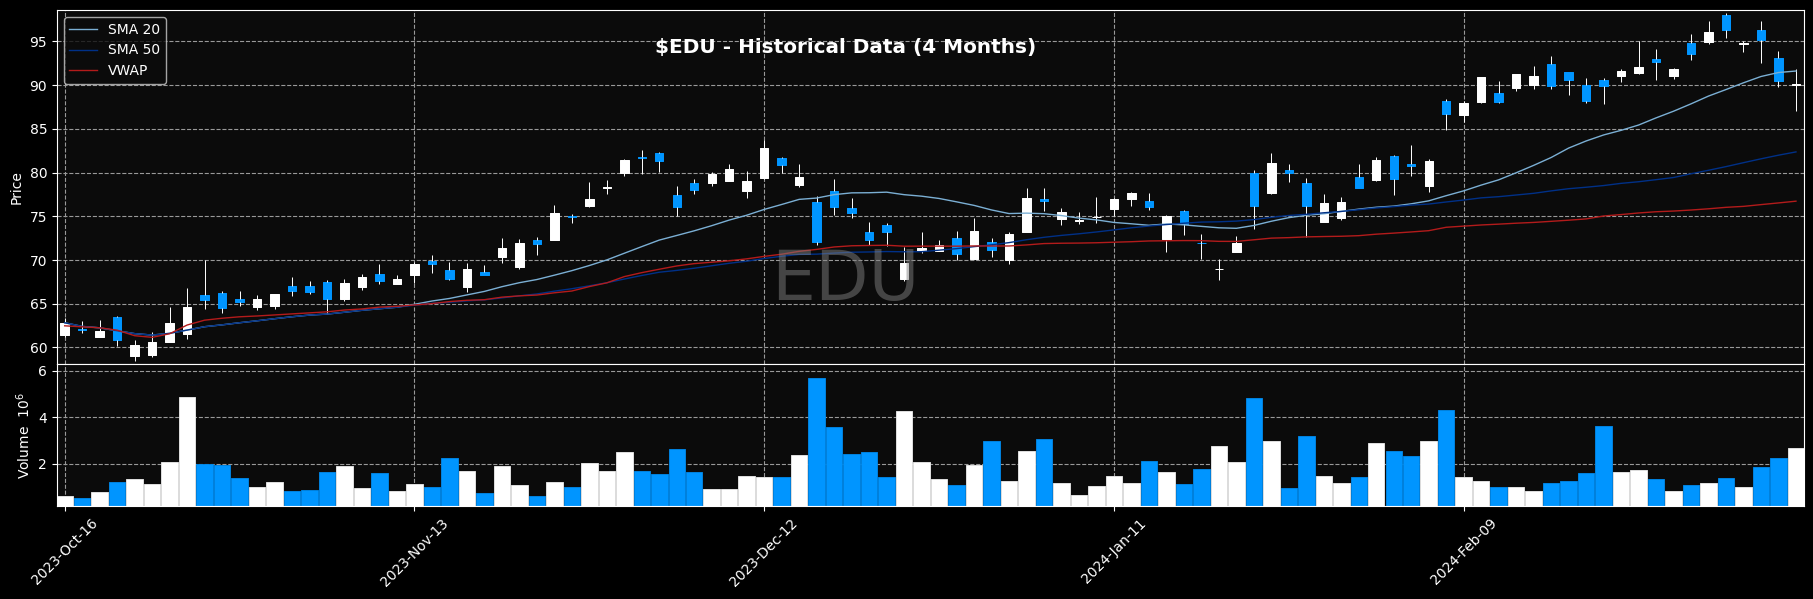

In [163]:
#### EXECUTE ####
plot_symbol_technicals(chart_historical_df, 'EDU')


In [156]:
#### KEY LEVELS ####
mtn_df = chart_historical_df[chart_historical_df['symbol'] == 'MTN'].copy()
mtn_df['date'] = pd.to_datetime(mtn_df['date'])
mtn_df.set_index('date', inplace=True)
mtn_df.head(2)

,symbol,close,high,low,open,volume,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20,RSI,ATR
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-17,MTN,224.93,227.515,221.93,222.63,495389.0,55.6040,62.7400,45.678933,89.977025,67.978999,59.195752,57.890011,6.624742,-2.629344,9.254086,60.2767,83.033658,226.344015,-105.790615,224.791667,60.135463,82.770957,225.677378,-105.406451,NaN,NaN
2023-10-18,MTN,222.88,224.290,221.76,223.13,445431.0,55.2056,45.2726,48.716400,87.861060,64.813350,55.870917,54.795413,6.775568,-2.623508,9.399076,54.0063,75.255222,204.516744,-96.504144,222.976667,53.927183,75.051451,204.030086,-96.175719,61.78645,66.398429


In [157]:
import mplfinance as mpf
# candlestick chart
# MANDATORY DATA = 'open', 'high', 'low', 'close', 'volume'
"""
Part 1: CALCULATE TECHNICAL INDICATORS
"""
mtn_df['SMA20'] = mtn_df['close'].rolling(window=20, min_periods=1).mean()
mtn_df['SMA50'] = mtn_df['close'].rolling(window=50, min_periods=1).mean()
mtn_df['VWAP'] = (mtn_df['volume'] * (mtn_df['high'] + mtn_df['low'] + mtn_df['close']) / 3).cumsum() / mtn_df['volume'].cumsum()


In [158]:
"""
Part 2: PREPARE DATA FOR CHARTING
"""
add2plot = [
    mpf.make_addplot(mtn_df['SMA20'], color='#7BAFD4', width=1.0, label='SMA 20'), 
    mpf.make_addplot(mtn_df['SMA50'], color='#003087', width=1.0, label='SMA 50'), 
    mpf.make_addplot(mtn_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP') 
]


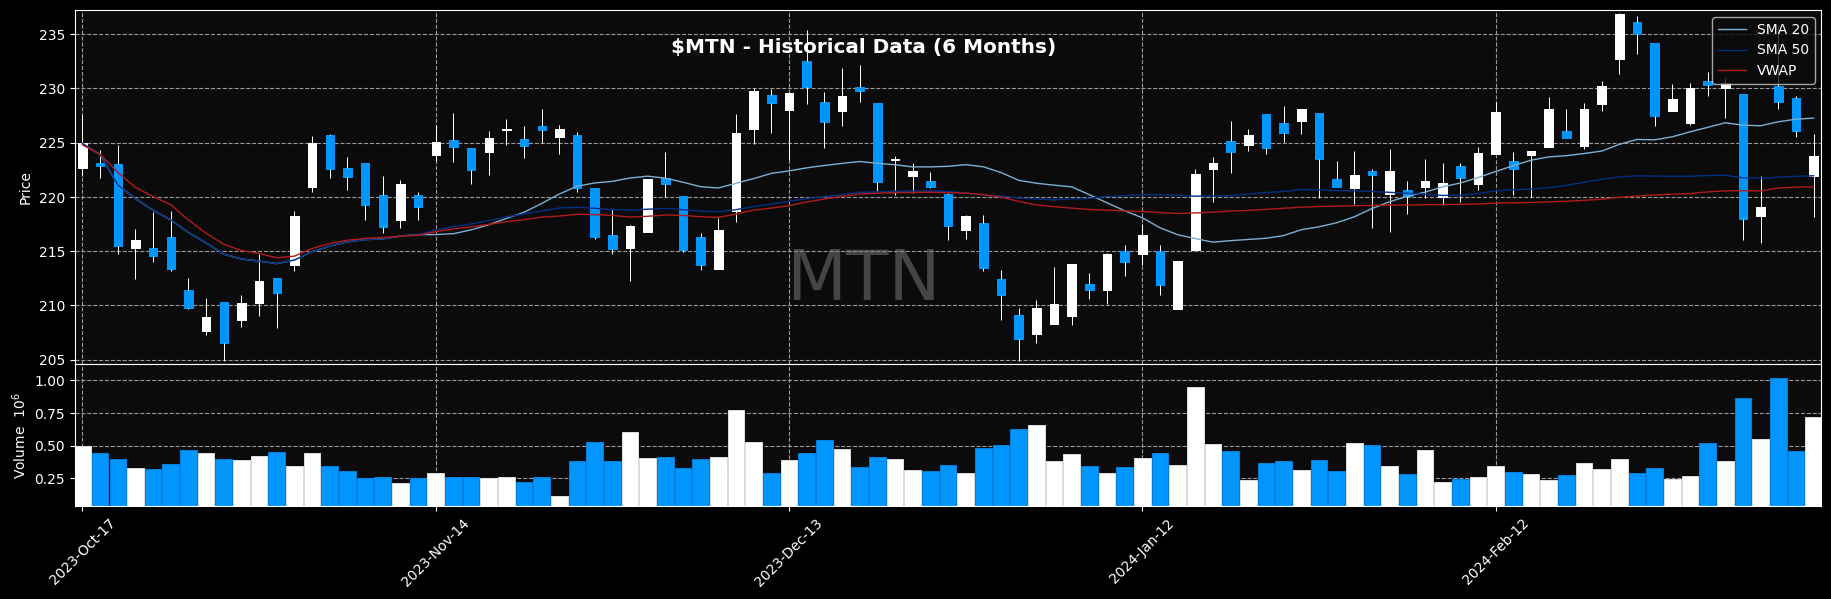

In [159]:
"""   
Part 3: STYLING AND PLOTTING (EXECUTION)
"""
mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})

fig, axes = mpf.plot(mtn_df,
                     type='candle',
                     addplot=add2plot,
                     volume=True,
                     style=mpf_style,
                     figratio=(42, 12),
                     title='$MTN - Historical Data (4 Months)',
                     tight_layout=True,
                     returnfig=True)

fig.text(0.5, 0.5, 'MTN', fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

plt.show()


| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [119]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [120]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [121]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [122]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [123]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [124]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [125]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [126]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)